In [1]:
import glob
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

# Camera calibration

CameraCalibration class handles all methods related to camera calibration.
If the constructor is called with the path of calibration image files, a new calibration process will be executed. Camera matrix and distortion coefficients will be stored in a dump. Later if the constructor is called without the path, the formerly generated camera parameters will be loaded from the dump.
If you want to make an indistortion on an image you can call the `undistort` method.

In [2]:
class CameraCalibration:
    def __init__(self, nCols = 9, nRows = 6, calibrationFiles = None):
        """Creates a camera calibration object

        nCols - Number of columns
        nRows - Number of rows
        calibrationFiles - Files calibration based on. If None camera parameters will be loaded from a pickle binary.
        """
        self._nRows = nRows
        self._nCols = nCols
        self._pickleFilename = 'camera_parameters.p'
        if calibrationFiles != None:
            self._cameraMatrix, self._distCoeffs = self._calibrate(calibrationFiles)
        else:
            cameraParams = pickle.load(open(self._pickleFilename, 'rb'))
            self._cameraMatrix = cameraParams['cameraMatrix']
            self._distCoeffs = cameraParams['distCoeffs']

    def _calibrate(self, path):
        """Calibrates the camera

        path - Files of image calibration based on.
        
        Returns camera matrix and distortion coefficients
        """
        coordinates = np.zeros((self._nRows * self._nCols, 3), np.float32)
        coordinates[:, :2] = np.mgrid[0 : self._nCols, 0 : self._nRows].T.reshape(self._nCols * self._nRows, 2)
        objectPoints = []
        imagePoints = []
        calibrationFiles = glob.glob(path)
        for idx, filename in enumerate(calibrationFiles):
            colorImage = cv2.imread(filename) # in BGR
            grayscaleImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2GRAY)
            retVal, corners = cv2.findChessboardCorners(grayscaleImage, (self._nCols, self._nRows))
            if retVal: # it is not sure all chessboard corners are found
                objectPoints.append(coordinates)
                imagePoints.append(corners)
        retVal, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, (1280, 720), None, None)
        pickle.dump({'cameraMatrix': cameraMatrix, 'distCoeffs': distCoeffs}, open(self._pickleFilename, 'wb'))
        return cameraMatrix, distCoeffs

    def undistort(self, image):
        """Undistort an image

        image - Image what will be undistorted
        
        Returns the undistorted image
        """
        return cv2.undistort(image, self._cameraMatrix, self._distCoeffs)

First time the camera must be calibrated using the calibration images.

In [3]:
camera = CameraCalibration(9,6,'camera_cal/calibration*.jpg')

Helper function to show two images

In [4]:
def plotImages(image1, title1, image2, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
    ax1.set_title(title1, fontsize=16)
    ax1.imshow(image1)
    ax2.set_title(title2, fontsize=16)
    ax2.imshow(image2, cmap = 'gray')
    return fig

Distortion correction for chessboard image

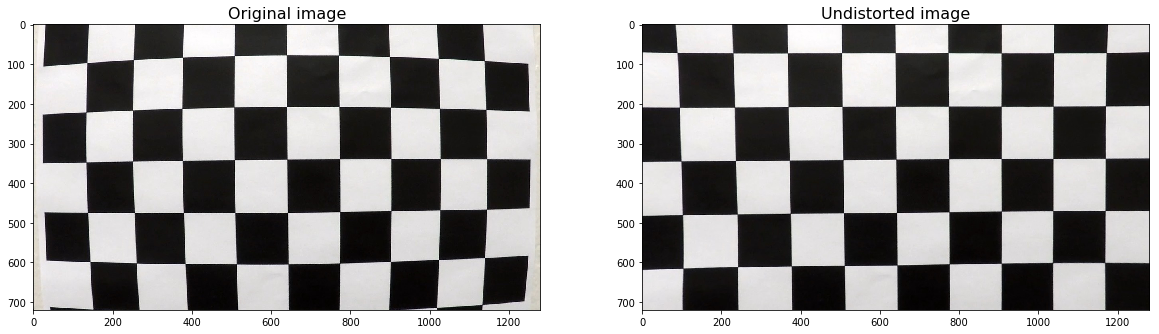

In [5]:
image1 = plt.imread('camera_cal/calibration1.jpg')
image2 = camera.undistort(image1)
fig = plotImages(image1, 'Original image', image2, 'Undistorted image')
fig.savefig('output_images/chessboard.jpg')

Distortion correction for an image of the highway

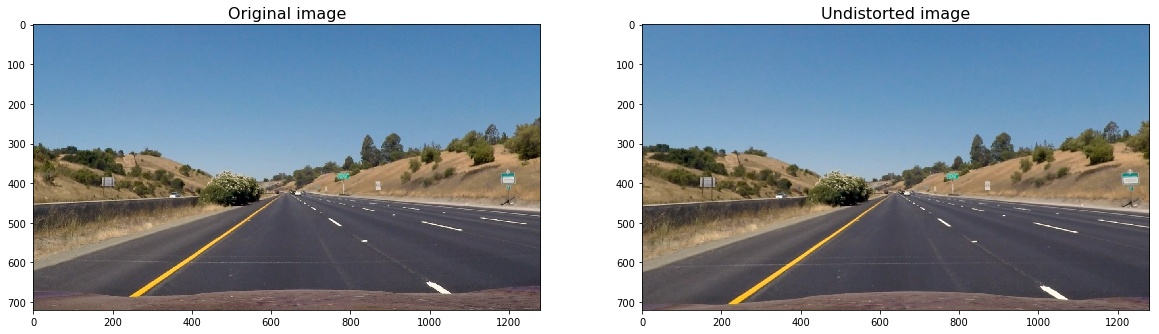

In [6]:
image1 = plt.imread('test_images/straight_lines1.jpg')
image2 = camera.undistort(image1)
fig = plotImages(image1, 'Original image', image2, 'Undistorted image')
fig.savefig('output_images/undistorted_road.jpg')

# Color transform and gradients

In [7]:
class GradientsAndColor:
    def __init__(self, image):
        self._image = image
        self._hlsImage = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HLS)
        self._hsvImage = cv2.cvtColor(np.copy(image), cv2.COLOR_RGB2HSV)

    def colorAndGradientFiltering(self):
        binaryImage = np.zeros_like(self._image[:,:,0])
        binaryImage[self.mask()] = 1
        return np.dstack((binaryImage, binaryImage, binaryImage)) * 255
    
    def sobelXInLChannel(self, lowThreshold, highThreshold):
        sobelX = cv2.Sobel(self._hlsImage[:,:,1], cv2.CV_64F, 1, 0)
        absSobelX = np.absolute(sobelX)
        scaledSobel = np.uint8(255 * absSobelX / np.max(absSobelX))
        return ((lowThreshold <= scaledSobel) & (scaledSobel <= highThreshold))

    def sChannel(self, lowThreshold, highThreshold):
        sChannel = self._hlsImage[:,:,2]
        return ((lowThreshold <= sChannel) & (sChannel <= highThreshold))

    def yellowLanes(self, lowThreshold, highThreshold):
        hChannel = self._hsvImage[:,:,0]
        sChannel = self._hsvImage[:,:,1]
        vChannel = self._hsvImage[:,:,2]
        return ((lowThreshold[0] < hChannel) & (hChannel < highThreshold[0]) & (lowThreshold[1] < sChannel) & (sChannel < highThreshold[1]) & (lowThreshold[2] < vChannel) & (vChannel < highThreshold[2]))

    def mask(self):
        return self.sobelXInLChannel(20, 100) | self.sChannel(170, 255) | self.yellowLanes([0, 80, 200],[40, 255, 255])

Yellow pixels are detected using hsv color space. The applied mask covers pixels with H values between 0 and 40, S values between 80 and 255, and V values between 200 and 255.

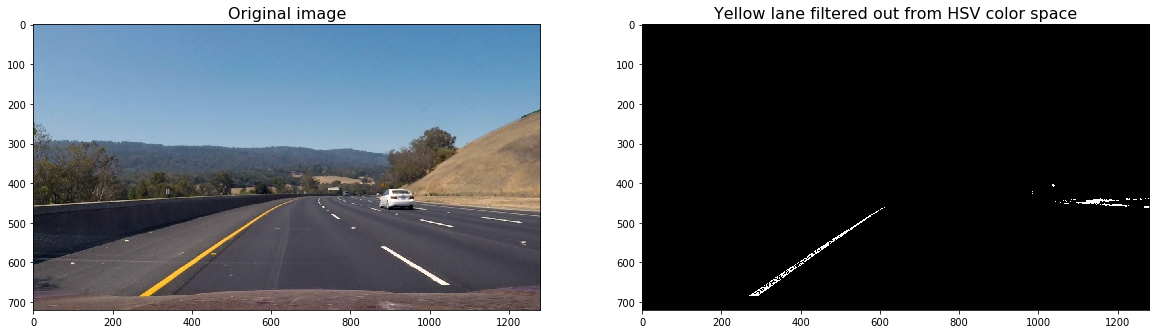

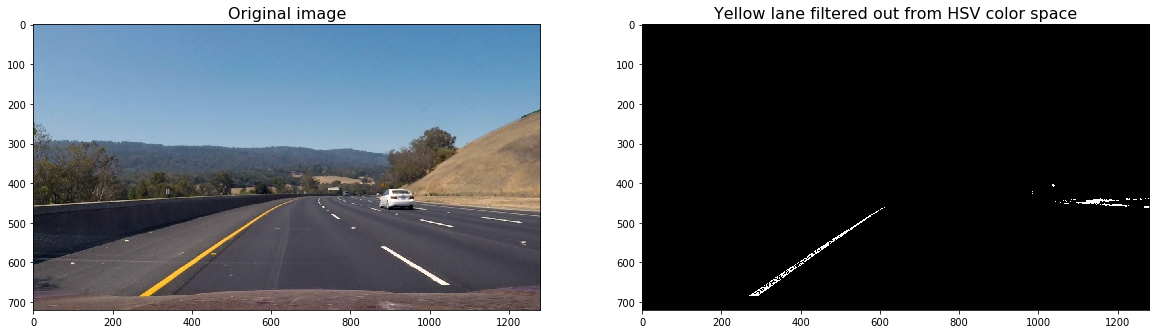

In [8]:
image = plt.imread('test_images/test3.jpg')
colorAndGradientTransform = GradientsAndColor(image)
yellowLanes = colorAndGradientTransform.yellowLanes([0, 80, 200],[40, 255, 255])
plotImages(image, 'Original image', yellowLanes, 'Yellow lane filtered out from HSV color space')

The S channel of HLS color space can be used to detect pixels with high saturation value.

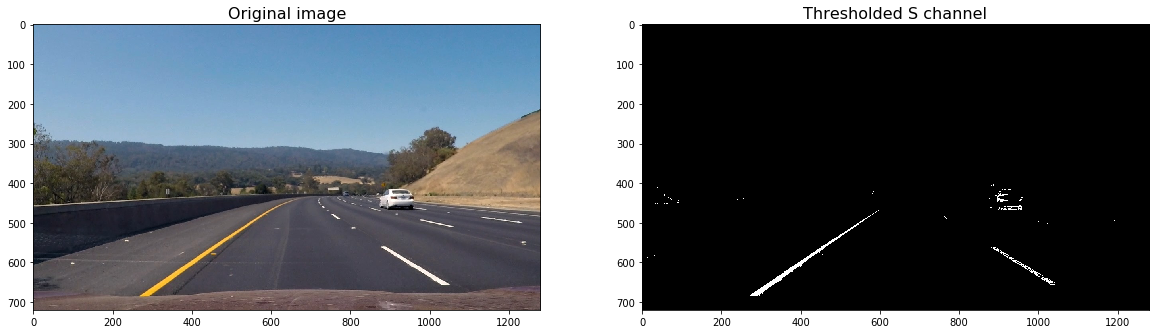

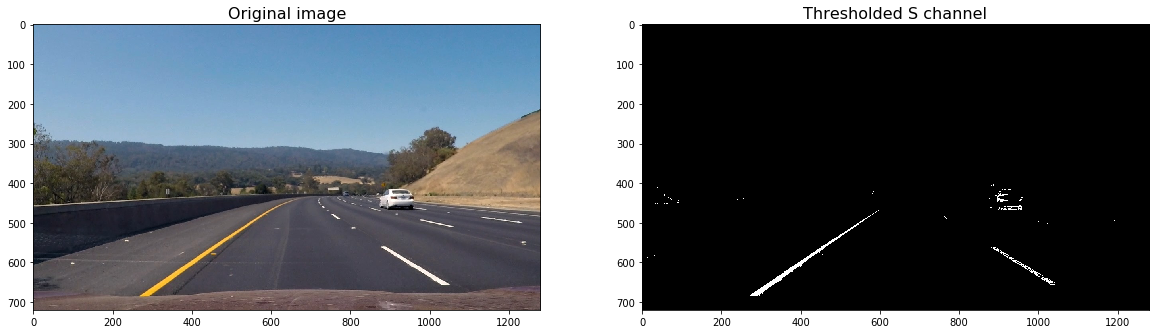

In [9]:
sChannel = colorAndGradientTransform.sChannel(170, 255)
plotImages(image, 'Original image', sChannel, 'Thresholded S channel')

In L channel of HSL color space horizontal sobel gradient is calculated and threshold of 20 and 100 is applied.

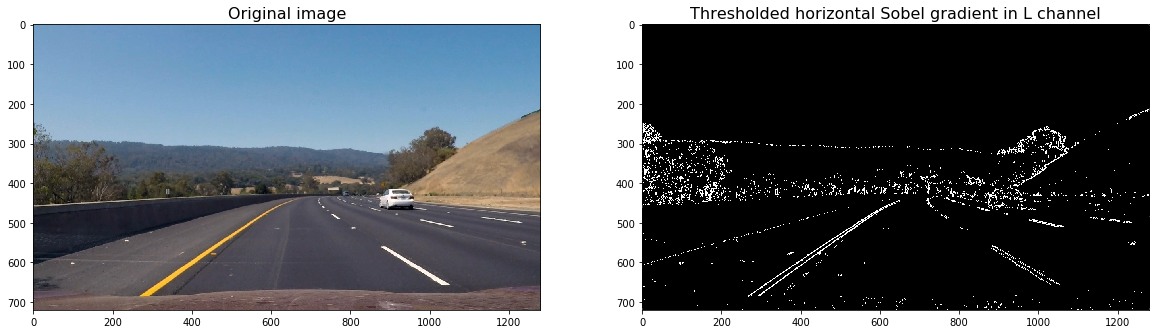

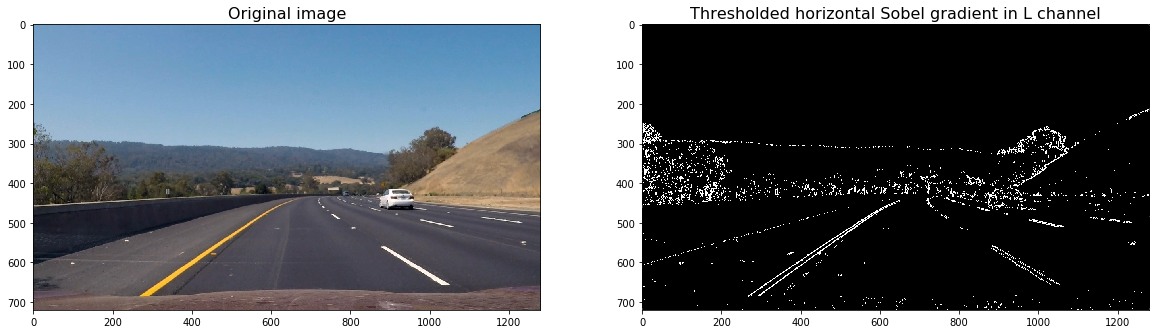

In [10]:
sobelInL = colorAndGradientTransform.sobelXInLChannel(20, 100)
plotImages(image, 'Original image', sobelInL, 'Thresholded horizontal Sobel gradient in L channel')

The combination of above mentioned three masks were applied in the project.

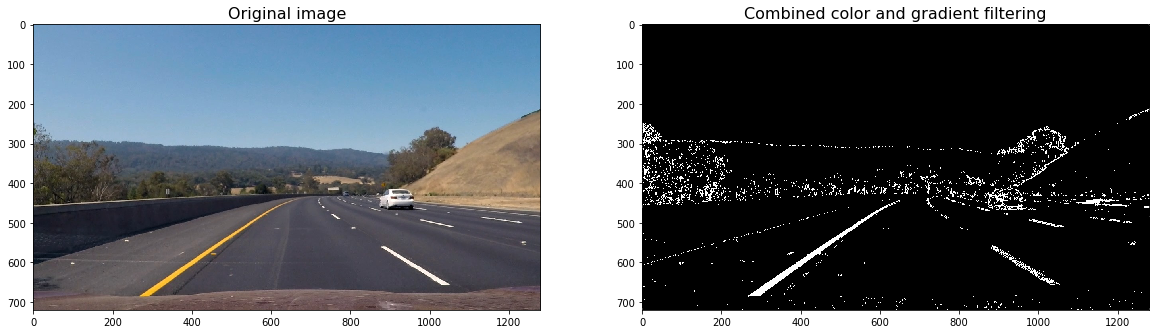

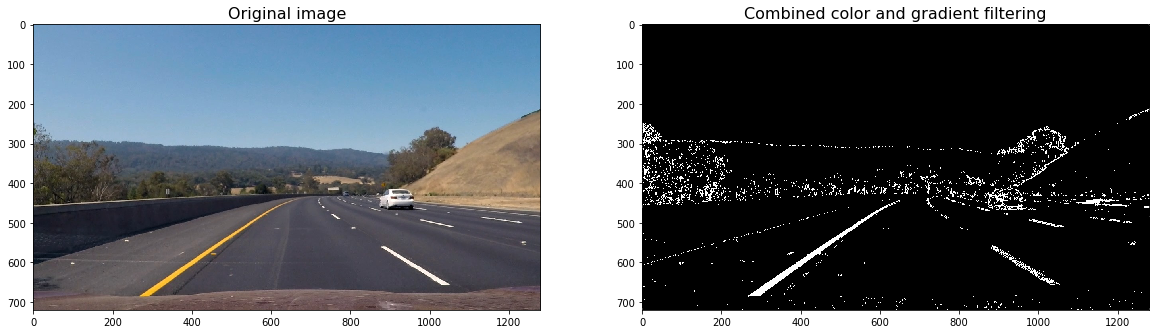

In [11]:
combinedFiltering = colorAndGradientTransform.colorAndGradientFiltering()
plotImages(image, 'Original image', combinedFiltering, 'Combined color and gradient filtering')

# Perspective transform

Class representing perspective transform

In [12]:
class PerspectiveTransform:
    def __init__(self, imageSize):
        """Creates  perspective transform object

        imageSize - width and height of an image
        """
        self._imageSize = imageSize
        self._sourcePoints = self._createSource()
        self._destinationPoints = self._createDestination()
        self._transformationMatrix = cv2.getPerspectiveTransform(self._sourcePoints, self._destinationPoints)
        self._inverseTransformationMatrix = cv2.getPerspectiveTransform(self._destinationPoints, self._sourcePoints)
        
    def _createSource(self):
        """Creates source matrix
        
        Results source matrix representing a trapezoid
        """
        xOffsetBottom = 200
        xOffsetMiddle = 595
        yOffset = 450
        sourceBottomLeft = (xOffsetBottom, self._imageSize[1])
        sourceBottomRight = (self._imageSize[0] - xOffsetBottom, self._imageSize[1])
        sourceTopLeft = (xOffsetMiddle, yOffset)
        sourceTopRight = (self._imageSize[0] - xOffsetMiddle, yOffset)
        return np.float32([sourceBottomLeft, sourceTopLeft, sourceTopRight, sourceBottomRight])

    def _createDestination(self):
        """Creates destination matrix

        Results destination matrix representing a rectangle
        """
        xOffset = self._imageSize[0] / 4
        destinationBottomLeft = (xOffset, self._imageSize[1])
        destinationBottomRight = (self._imageSize[0] - xOffset, self._imageSize[1])
        destinationTopLeft = (xOffset, 0)
        destinationTopRight = (self._imageSize[0] - xOffset, 0)
        return np.float32([destinationBottomLeft, destinationTopLeft, destinationTopRight, destinationBottomRight])

    def getSourcePoints(self):
        """Getter for source points

        Results source points representing a trapezoid
        """
        return self._sourcePoints

    def getDestinationPoints(self):
        """Getter for destination points

        Results destination points representing a rectangle
        """
        return self._destinationPoints

    def warp(self, image):
        """Warps an image

        Warps an image using perspective transform
        """
        return cv2.warpPerspective(image, self._transformationMatrix, self._imageSize)

    def unWarp(self, image):
        """Unwarps an image

        Unwarps an image using inverse perspective transform
        """
        return cv2.warpPerspective(image, self._inverseTransformationMatrix, self._imageSize)


In [13]:
perspectiveTransform = PerspectiveTransform((1280, 720))

A trapezoid area of the undistorted image were selected and a perspective transform was used in order to warp the image into a rectangular are. It makes the image as a bird's eye view image.

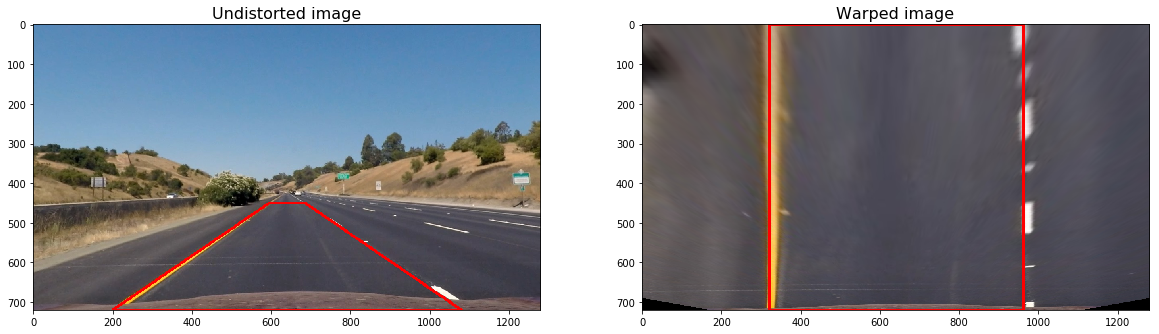

In [14]:
image = plt.imread('test_images/straight_lines1.jpg')
undistortedImage = camera.undistort(image)
transformedImage = perspectiveTransform.warp(undistortedImage)
image1 = cv2.polylines(undistortedImage, [np.array(perspectiveTransform.getSourcePoints(), np.int32)], True, (255, 0, 0), 5)
image2 = cv2.polylines(transformedImage, [np.array(perspectiveTransform.getDestinationPoints(), np.int32)], True, (255, 0, 0), 5)
fig = plotImages(image1, 'Undistorted image', image2, 'Warped image')
fig.savefig('output_images/perspective_transform.jpg')

# Lane finding

In [15]:
class LaneProcessor:
    def __init__(self, binaryImage):
        """Creates a lane processor object regarding one binary image
        """
        self._nWindows = 9
        self._margin = 75
        self._minNumberOfPixels = 50
        self._originalBinaryImage = binaryImage
        self._binaryImage = binaryImage[:, :, 0]
        self._imageWidth = binaryImage.shape[1]
        self._imageHeight = binaryImage.shape[0]
        self._leftPlotX = None
        self._leftPlotY = None
        self._rightPlotX = None
        self._rightPlotY = None
        self._leftCurvatureRadian = None
        self._rightCurvatureRadian = None
        
    def getLeftPlotX(self):
        return self._leftPlotX

    def getRightPlotX(self):
        return self._rightPlotX

    def sanityCheck(self):
        maxDistanceOfTwoLanes = np.mean((self._rightPlotX - self._leftPlotX) * 3.7 / 640)
        if 3.4 > maxDistanceOfTwoLanes or maxDistanceOfTwoLanes > 4.0:
            return False
        if self._leftCurvatureRadian < 1000 and self._rightCurvatureRadian < 1000:
            ratio = self._rightCurvatureRadian / self._leftCurvatureRadian
            if ratio < 0.5 or ratio > 2:
                return False
        return True

    def getLeftCurvatureRadian(self):
        """Getter for left curvature radian"""
        return self._leftCurvatureRadian

    def getRightCurvatureRadian(self):
        """Getter for right curvature radian"""
        return self._rightCurvatureRadian

    def getXOffset(self):
        """Calculates the offset of the car in the lane"""
        middleOfTheLane = (self._leftPlotX[-1] + self._rightPlotX[-1]) / 2
        currentXPositions = self._imageWidth / 2
        diffInMeters = (currentXPositions - middleOfTheLane) * 3.7 / 640
        return diffInMeters

    def drawLanes(self):
        """Draws lanes which were previously generated by genarateLanePixels method"""
        image = np.zeros_like(self._originalBinaryImage).astype(np.uint8)
        leftPoints = np.array([np.transpose(np.vstack([self._leftPlotX, self._leftPlotY]))])
        rightPoints = np.array([np.flipud(np.transpose(np.vstack([self._rightPlotX, self._rightPlotY])))])
        points = np.hstack((leftPoints, rightPoints))
        return cv2.fillPoly(image, np.int_([points]), (0, 255, 0))
    
    def drawLanesWith(self, leftPlotX, rightPlotX):
        """Draws lanes with the parameters as lane x coordinates"""
        image = np.zeros_like(self._originalBinaryImage).astype(np.uint8)
        plotY = np.linspace(0, self._imageHeight - 1, self._imageHeight)
        leftPoints = np.array([np.transpose(np.vstack([leftPlotX, plotY]))])
        rightPoints = np.array([np.flipud(np.transpose(np.vstack([rightPlotX, plotY])))])
        points = np.hstack((leftPoints, rightPoints))
        return cv2.fillPoly(image, np.int_([points]), (255, 0, 0))

    def generateLanePixels(self):
        """Generates the lane pixels and curvature values"""
        histogram = self.histogramOfLowerPart()
        leftBaseX = self.baseLeftX(histogram)
        rightBaseX = self.baseRightX(histogram)
        nonZeros = self.nonZeroPixels()
        leftX, leftY = self.findLanePixelsOfOneLane(nonZeros, leftBaseX)
        rightX, rightY = self.findLanePixelsOfOneLane(nonZeros, rightBaseX)
        leftFitPolynomial = np.polyfit(leftY, leftX, 2)
        rightFitPolynomial = np.polyfit(rightY, rightX, 2)
        self._leftPlotX, self._leftPlotY = self.pixelsForPlotting(leftFitPolynomial)
        self._rightPlotX, self._rightPlotY = self.pixelsForPlotting(rightFitPolynomial)
        self._leftCurvatureRadian = self.calculateCurvature(leftX, leftY)
        self._rightCurvatureRadian = self.calculateCurvature(rightX, rightY)
        return

    def histogramOfLowerPart(self):
        """Creates the histogram of the lower part of the image"""
        return np.sum(self._binaryImage[self._imageHeight // 2:, :], 0)

    def baseLeftX(self, histogram):
        """Results the histogram peak on the left hand side"""
        return np.argmax(histogram[:self._imageWidth // 2])

    def baseRightX(self, histogram):
        """Results the histogram peak on the right hand side"""
        middlePoint = self._imageWidth // 2
        return np.argmax(histogram[middlePoint:]) + middlePoint

    def nonZeroPixels(self):
        """Results all nonzero pixels of the image"""
        nonZeros = self._binaryImage.nonzero()
        return np.array(nonZeros[1]), np.array(nonZeros[0]) # x and y coordinates of nonzeros

    def findLanePixelsOfOneLane(self, nonzeros, baseXCoordinate, plotWindows=False):
        """Find the lane pixels using windowing technique"""
        windowHeight = np.int(self._imageHeight / self._nWindows)
        nonZeroPixelsYCoors = nonzeros[1]
        nonZeroPixelsXCoors = nonzeros[0]
        
        if plotWindows:
            outImage = np.copy(self._originalBinaryImage)

        currentXCoordinate = baseXCoordinate
        laneIndices = []
        for window in range(self._nWindows):
            lowYInWindow = self._imageHeight - (window + 1) * windowHeight
            highYInWindow = self._imageHeight - window * windowHeight
            lowXInWindow = currentXCoordinate - self._margin
            highXInWindow = currentXCoordinate + self._margin

            goodIndices = ((lowYInWindow <= nonZeroPixelsYCoors) & (nonZeroPixelsYCoors < highYInWindow) & (lowXInWindow <= nonZeroPixelsXCoors) & (nonZeroPixelsXCoors < highXInWindow)).nonzero()[0]
            laneIndices.append(goodIndices)
            if len(goodIndices) > self._minNumberOfPixels:
                currentXCoordinate = np.int(np.mean(nonZeroPixelsXCoors[goodIndices]))
                
            if plotWindows:
                cv2.rectangle(outImage, (lowXInWindow, lowYInWindow), (highXInWindow, highYInWindow), (0, 255, 0), 3)

        try: 
            laneIndices = np.concatenate(laneIndices)
        except ValueError:
            pass

        finalXCoordinates = nonZeroPixelsXCoors[laneIndices]
        finalYCoordinates = nonZeroPixelsYCoors[laneIndices]
        if plotWindows:
            plt.imshow(outImage)
        return finalXCoordinates, finalYCoordinates

    def pixelsForPlotting(self, fittingPolynomial):
        """Generates pixels for plotting a lane"""
        yValues = np.linspace(0, self._imageHeight - 1, self._imageHeight)
        try:
            fittingXCoordinates = fittingPolynomial[0] * yValues**2 + fittingPolynomial[1] * yValues + fittingPolynomial[2]
        except TypeError:
            fittingXCoordinates = yValues**2 + yValues
        return fittingXCoordinates, yValues

    def calculateCurvature(self, xCoordinates, yCoordinates):
        """Calculates the curvature of a lane"""
        yMetersPerPixel = 35 / self._imageHeight
        xMetersPerPixel = 3.7 / 640
        fittingPolynomial = np.polyfit(yCoordinates * yMetersPerPixel, xCoordinates * xMetersPerPixel, 2)
        yValues = np.linspace(0, self._imageHeight - 1, self._imageHeight)
        curveRad = ((1 + (2 * fittingPolynomial[0] * np.max(yValues) * yMetersPerPixel + fittingPolynomial[1])**2)**1.5) / np.abs(2 * fittingPolynomial[0])
        return curveRad

The input of the lane finder is bird's eye view binary image after color and gradient thresholding.

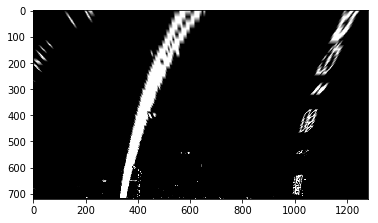

In [16]:
image = plt.imread('test_images/test3.jpg')
gradAndColor = GradientsAndColor(camera.undistort(image))
birdsEyeViewImage = perspectiveTransform.warp(gradAndColor.colorAndGradientFiltering())
plt.imshow(birdsEyeViewImage)

First the histogram of the lower part of the image were calculated along a horizontal line. In the histogram two peaks were detected, one on the left part and another one on the right part. These peak values will be the starting points of windowing method.

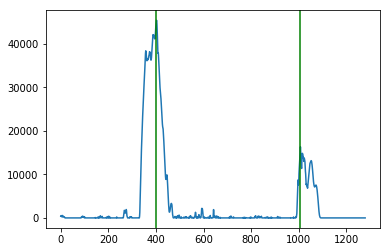

In [17]:
laneFinder = LaneProcessor(birdsEyeViewImage)
hist = laneFinder.histogramOfLowerPart()
baseLeftX = laneFinder.baseLeftX(hist)
baseRightX = laneFinder.baseRightX(hist)
plt.plot(hist)
plt.axvline(baseLeftX, color='g')
plt.axvline(baseRightX, color='g')

To detect lane pixels a windowing method was applied. The image vertically were divided into 9 equal parts. In each part a window was defined with 150 pixels width. The loop started from the most bottom window. In a window the pixels were selected, and the mean of these pixels' x coordinates determined the base value of the following window.
In the next image an example is presented for the left part of the image.

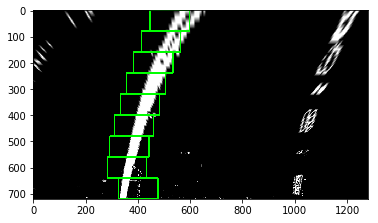

In [18]:
nonzeros = laneFinder.nonZeroPixels()
leftX, leftY = laneFinder.findLanePixelsOfOneLane(nonzeros, baseLeftX, True)

Here is the result for the right part.

(array([ 997,  998,  999, ..., 1202, 1203, 1204]),
 array([640, 640, 640, ...,  79,  79,  79]))

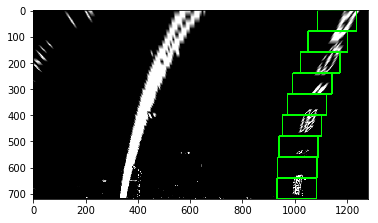

In [19]:
laneFinder.findLanePixelsOfOneLane(nonzeros, baseRightX, True)

Using both lanes a stripe can be plotted to the image.

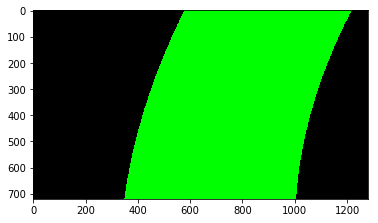

In [20]:
laneFinder.generateLanePixels()
stripe = laneFinder.drawLanes()
plt.imshow(stripe)

This stripe should be unwarp to the original image.

True

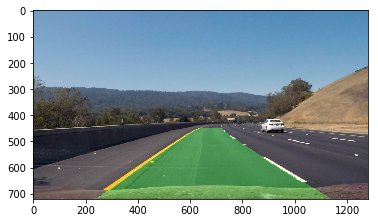

In [21]:
unwarpedStripe = perspectiveTransform.unWarp(stripe)
imageWithStripe = cv2.addWeighted(image, 1, unwarpedStripe, 0.3, 0)
plt.imshow(imageWithStripe)
cv2.imwrite('output_images/stripe.jpg', cv2.cvtColor(imageWithStripe, cv2.COLOR_RGB2BGR))

In [22]:
class FormerLanes:
    def __init__(self):
        self._left = []
        self._right = []
        self._leftCurvature = []
        self._rightCurvature = []
        self._offset = []

    def getLeft(self):
        return self._left[-1]

    def getRight(self):
        return self._right[-1]

    def getLeftCurvature(self):
        return self._leftCurvature[-1]

    def getRightCurvature(self):
        return self._rightCurvature[-1]

    def getOffset(self):
        return self._offset[-1]

    def newLeft(self, left):
        self._left.append(left)
        return

    def newRight(self, right):
        self._right.append(right)
        return

    def newLeftCurvature(self, leftCurvature):
        self._leftCurvature.append(leftCurvature)
        return

    def newRightCurvature(self, rightCurvature):
        self._rightCurvature.append(rightCurvature)
        return

    def newOffset(self, offset):
        self._offset.append(offset)
        return

# Pipeline

In [23]:
camera = CameraCalibration(9, 6)
perspectiveTransform = PerspectiveTransform((1280, 720))
formerLanes = FormerLanes()
def processImage(image):
    undistortedImage = camera.undistort(image)
    gradientsAndColor = GradientsAndColor(undistortedImage)
    lanePixelCandidates = gradientsAndColor.colorAndGradientFiltering()
    warpLanes = perspectiveTransform.warp(lanePixelCandidates)
    laneProcessor = LaneProcessor(warpLanes)
    laneProcessor.generateLanePixels()
    if laneProcessor.sanityCheck():
        drawnLanes = laneProcessor.drawLanes()
        formerLanes.newLeft(laneProcessor.getLeftPlotX())
        formerLanes.newRight(laneProcessor.getRightPlotX())
        leftCurvatureRadian = laneProcessor.getLeftCurvatureRadian()
        formerLanes.newLeftCurvature(leftCurvatureRadian)
        rightCurvatureRadian = laneProcessor.getRightCurvatureRadian()
        formerLanes.newRightCurvature(rightCurvatureRadian)
        xOffset = laneProcessor.getXOffset()
        formerLanes.newOffset(xOffset)
    else:
        drawnLanes = laneProcessor.drawLanesWith(formerLanes.getLeft(), formerLanes.getRight())
        leftCurvatureRadian = formerLanes.getLeftCurvature()
        rightCurvatureRadian = formerLanes.getRightCurvature()
        prevXOffset = formerLanes.getOffset()
    unWarpedLanes = perspectiveTransform.unWarp(drawnLanes)
    newImage = cv2.addWeighted(undistortedImage, 1, unWarpedLanes, 0.3, 0)
    leftCurvatureRadian = laneProcessor.getLeftCurvatureRadian()
    rightCurvatureRadian = laneProcessor.getRightCurvatureRadian()
    xOffset = laneProcessor.getXOffset()
    text1 = 'Left curvature: {0:5.0f} meters, right curvature: {1:5.0f} meters'.format(leftCurvatureRadian, rightCurvatureRadian)
    text2 = 'Horizontal car offset: {0:.2f} meters'.format(xOffset)
    newImage = cv2.putText(newImage, text1, (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return cv2.putText(newImage, text2, (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

In [24]:
inputVideo = VideoFileClip(filename = './project_video.mp4')
outputVideoFile = './result_project_video.mp4'
outputVideo = inputVideo.fl_image(image_func = processImage)
outputVideo.write_videofile(outputVideoFile, audio = False)

[MoviePy] >>>> Building video ./result_project_video.mp4
[MoviePy] Writing video ./result_project_video.mp4


100%|█████████▉| 1260/1261 [04:46<00:00,  4.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result_project_video.mp4 

